In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import ParameterMapper
from pyfoomb.utils import Helpers

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [2]:
import joblib
import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import time

# Set seed of random number generator for reproducibility
numpy.random.seed(1234)

# Settings for the `estimate_parallel` method and resulting effects


### Some helper functions for this notebook

In [3]:
# Creates a noisy dataset, based on a forward simulation
def noisy_samples(simulations, samples=5, rel_err=0.05, abs_err=0.05, repetitions=3, with_errors=True):
    artifical_data = []
    
    # get joint time points
    t_all = Helpers.get_unique_timepoints(simulations)

    # iterate over simulations
    for simulation in simulations:
        
        _name = simulation.name
        _replicate_id = simulation.replicate_id
        _t_samples = numpy.random.choice(simulation.timepoints, size=samples, replace=False)
        _sample_idxs = numpy.in1d(simulation.timepoints, _t_samples)
        _timepoints = simulation.timepoints[_sample_idxs]
        _values = simulation.values[_sample_idxs]
        
        # generate random samples
        _rnd_values = [
            numpy.random.normal(loc=_values, scale=abs(_values*rel_err+abs_err)) 
            for _ in range(repetitions)
        ]
        
        # create new Measurement object
        _measurement = Measurement(
            name=_name, 
            replicate_id=_replicate_id,
            timepoints=_timepoints, 
            values=numpy.mean(_rnd_values, axis=0),
            errors=numpy.std(_rnd_values, ddof=1, axis=0) if with_errors else None,
        )
        artifical_data.append(_measurement)
        
    return artifical_data

In [4]:
def make_experiment(caretaker:Caretaker, tfinal:float, samples:int=3, show:bool=True):
    
    simulation = caretaker.simulate(t=tfinal)
    data = noisy_samples(caretaker.simulate(t=numpy.arange(tfinal*4)/4), samples=samples)
    if show:
        _ncols = len(set([_item.name for _item in simulation]))
        _ = Visualization.show_kinetic_data(simulation, ncols=_ncols)
        _ncols = len(set([_item.name for _item in data]))
        _ = Visualization.show_kinetic_data(data, ncols=_ncols)

    return data, simulation

In [5]:
def extract_losses_times(results:list) -> tuple:
    """
    Helper function for `extract_results`.
    """
    
    _losses = [[numpy.min(_result.losses_trail[-1]) for _result in _results] for _results in results]
    _mean_losses = numpy.mean(_losses, axis=0)
    _std_losses = numpy.std(_losses, axis=0, ddof=1)
    
    _runtimes = [[numpy.min(_result.runtime_trail[-1]) for _result in _results] for _results in results]
    _mean_runtimes = numpy.mean(_runtimes, axis=0)
    _std_runtimes = numpy.std(_runtimes, axis=0, ddof=1)
    
    return _mean_losses, _std_losses,_mean_runtimes, _std_runtimes

In [6]:
def extract_results(results:list, parameter:str, parameter_values:list, decimals:int) -> int:
    """
    Extracts index of best parameter values, based on results from repeated application of these parameter values.
    Plots average losses and runtimes results from parameter tunings for visual inspection.
    
    Arguments
    ---------
        results : list
        parameter : str
        parameter_values : list
        decimals : int
        
    Returns
    -------
        best_parameter_index : int
            The index of the best parameter value, determined from the used heuristic.
    """
    
    repeats = len(results)
    
    _mean_losses, _std_losses, _mean_runtimes, _std_runtimes = extract_losses_times(results)
    _min_idx = numpy.argmin(_mean_losses)
    _shaved_losses = numpy.trunc(_mean_losses * 10**decimals) / 10**decimals
        
    _min_losses_idxs = numpy.where(_shaved_losses == numpy.min(_shaved_losses))[0]
    _t_opt = numpy.min(_mean_runtimes[_min_losses_idxs])
    best_parameter_index = numpy.argwhere(_mean_runtimes == _t_opt)[0][0]
    
    _x = [f'{_p_value}' for _p_value in parameter_values]
    
    fig, ax = pyplot.subplots(nrows=2, ncols=1, dpi=100, figsize=(10, max([1.3*len(_x), 4])))
    
    # Plot the losses
    ax[0].barh(
        _x, 
        _mean_losses,
        xerr=[-1*numpy.sign(_mean_losses)*_std_losses, numpy.zeros_like(_std_losses)],
        facecolor='lightgrey', edgecolor='black', height=0.7,
    )
    ax[0].set_xlabel(f'Loss (n = {repeats}, mean with std)', size=12)
    
    # Annotate the losses
    _min_idx = numpy.argmin(_mean_losses)
    for i in range(len(parameter_values)):
        if _mean_losses[i] < 0:
            _y = _mean_losses[i]-0.02*_mean_losses[_min_idx]
        else:
            _y = numpy.abs(0.02*_mean_losses[_min_idx])
        if i == best_parameter_index:
            _color = 'red'
        else:
            _color = 'black'
        _mean = _mean_losses[i]
        _std = _std_losses[i]
        ax[0].text(_y, i, f'{_mean:.8f}\n+/- {numpy.abs(_std/_mean*100):.6f} %', color=_color, va='center')
        
    # Plot the runtimes
    ax[1].barh(
        _x, 
        _mean_runtimes,
        xerr=[numpy.zeros_like(_std_runtimes), _std_runtimes], 
        facecolor='lightgrey', edgecolor='black', height=0.7,
    )
    _min_idx = numpy.argmin(_mean_runtimes)
    for i in range(len(parameter_values)):
        _y = 0.05*_mean_runtimes[_min_idx]
        if i == best_parameter_index:
            _color = 'red'
        else:
            _color = 'black'
        _mean = _mean_runtimes[i]
        _std = _std_runtimes[i]
        ax[1].text(_y, i, f'{_mean:.2f} min\n+/- {numpy.abs(_std/_mean*100):.1f} %', color=_color, va='center')
    ax[1].set_xlabel(f'Runtime in min (n = {repeats}, mean with std)', size=12)
    for _ax in ax.flat:
        _ax.set_ylabel(parameter, size=12)
    fig.tight_layout()
    
    return best_parameter_index

## 1. The bioprocess model

First, the bioprocess model is defined. This model is also used to generate some noisy artifical data to demonstrate the parameter estimation process.

In [7]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):
        
    def specific_growth_rate_mu(self, t, y):
        P, S, X = y
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        mu = mu_max * S / (kS + S)
        return mu
    
    def specific_production_rate_qP(self, t, y):
        P, S, X = y
        YPX = self.model_parameters['YPX']
        mu = self.specific_growth_rate_mu(t, y)
        qP = YPX * mu
        return qP
    
    def specific_substrate_consumption_rate_qS(self, t, y):
        P, S, X = y
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = 1/YXS * mu + 1/YPS * qP
        return qS
    
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = self.specific_substrate_consumption_rate_qS(t, y)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.6,
    'YPS' : 0.4,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}

# Instantiates are caretaker with two replicate_ids
caretaker = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

# Save for later comparison
_pars_for_comp = caretaker._get_all_parameters()

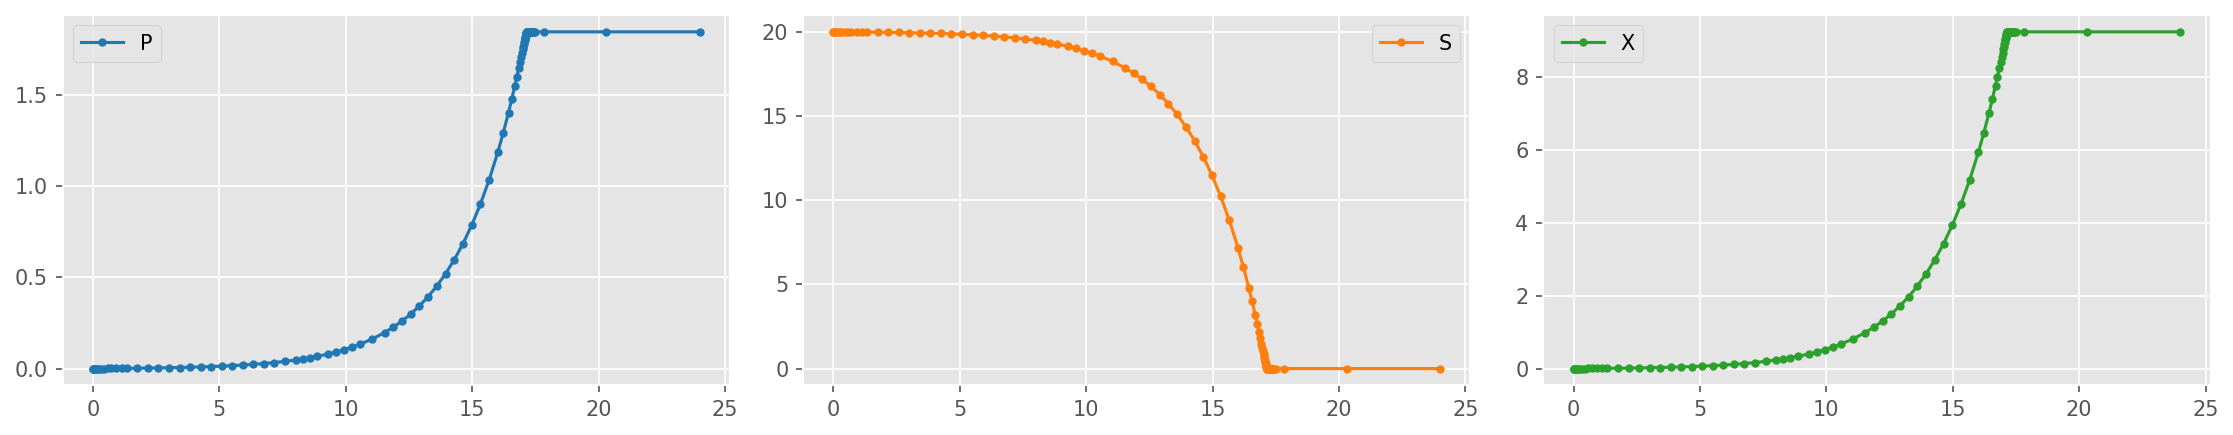

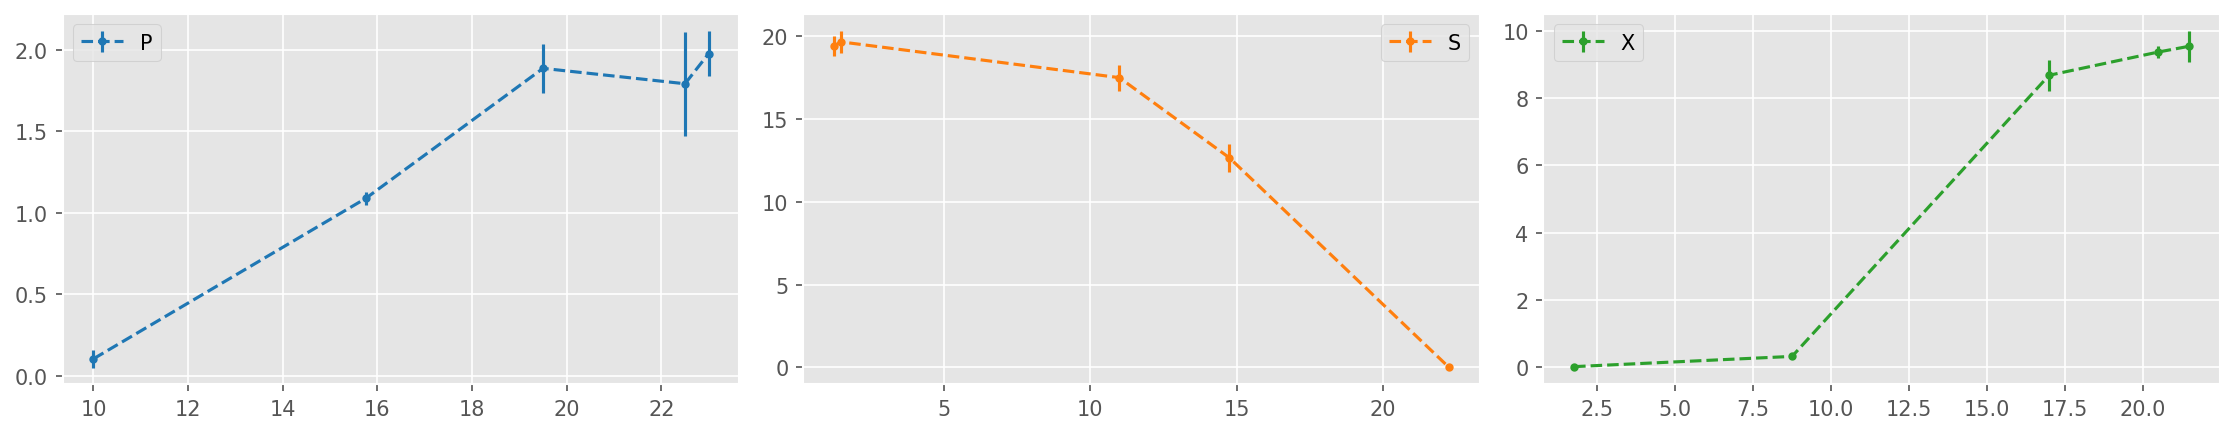

In [8]:
# Generates noisy artificial data from the simulation
data, simulation = make_experiment(caretaker, tfinal=24, samples=5)

In [9]:
# Defines the unknowns to be estimated, as well as corresponding bounds
unknowns = [
    'kS', 
    'mu_max', 
    'YXS', 
    'YPS', 
    'YPX',
    'S0',
]

bounds = [
    (0.01, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (17.5, 22.5),
]

max_evos = 1000 # To cope with the fact that different optimizers need different runtimes for an evolution
max_evotime = 5 # In min

In [10]:
def estimate_parallel_wrapper(settings:dict, repeats:int):
    _start = time.time()
    repeated_results = []
    for _repeat in range(repeats):
        print(f'Running repeat {_repeat+1} of {repeats} repeats')
        _results = []
        for _settings in settings:
            _, est_info = caretaker.estimate_parallel(
                unknowns=unknowns,
                bounds=bounds,
                measurements=data, 
                evolutions=max_evos,
                max_evotime_min=max_evotime,
                report_level=0,
                **_settings,
            )
            _results.append(est_info)
        repeated_results.append(_results)
    print(f'\nTotal runtime was {(time.time() - _start)/60:.2f} min')
    return repeated_results

In [11]:
# All comparisons will be run repeatedly to average corresponding results
repeats = 5

# The results will be evaluted based on the log-likelihoods, which are truncated or rounded at several decimals
decimals = 5

## 2. Settings for model calibation, using `de1220`

In [12]:
results_de1220 = {}
optimizer = 'de1220'

### 2.1. Convergence criterion `rtol_islands`

In [13]:
rtols = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

_settings = [
    {
        'optimizers' : optimizer, 
        'rtol_islands' : _rtol,
    } 
    for _rtol in rtols
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 31.43 min


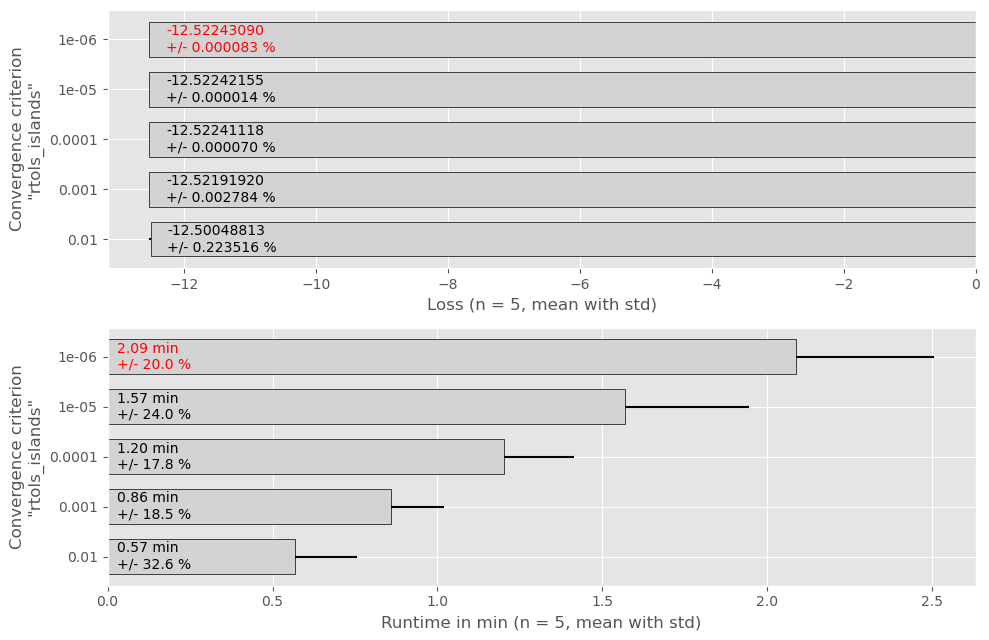

In [14]:
_best_index = extract_results(
    _results, 
    parameter='Convergence criterion\n"rtols_islands"', 
    parameter_values=rtols,
    decimals=decimals,
)

results_de1220['rtol_islands'] = rtols[_best_index]

### 2.2. Number of parallel CPUs

In [15]:
n_cpus = [2, 4, 6, 8, 12]

_settings = [
    {
        'optimizers' : [optimizer]*_n_cpus,
    } 
    for _n_cpus in n_cpus
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 28.57 min


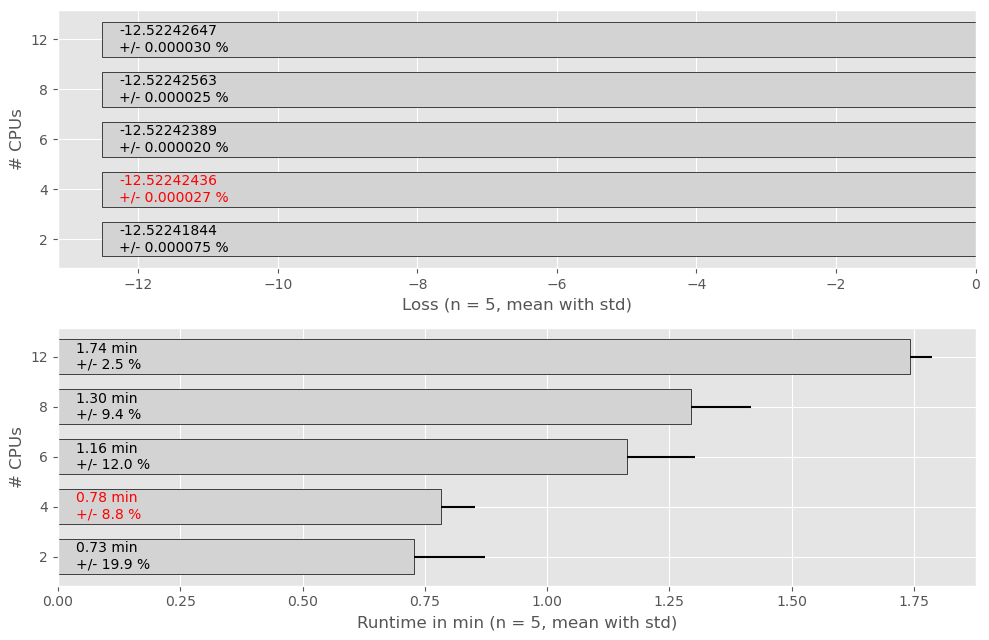

In [16]:
_best_index = extract_results(
    _results, 
    parameter='# CPUs', 
    parameter_values=n_cpus,
    decimals=decimals,
)

results_de1220['n_cpus'] = n_cpus[_best_index]

### 2.3. `de1220` parameter `gen`

In [17]:
gens = [5, 10, 25, 50, 100]

_settings = [
    {
        'optimizers' : optimizer, 
        'optimizers_kwargs' : {
            'gen' : _gen,
        },
    }
    for _gen in gens
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 46.53 min


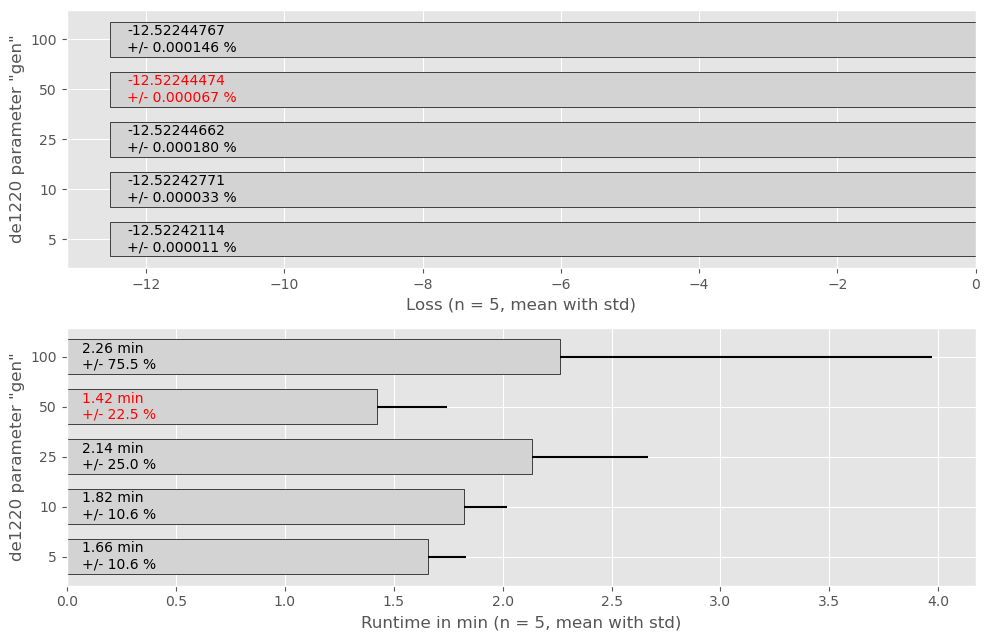

In [18]:
_best_index = extract_results(
    _results, 
    parameter='de1220 parameter "gen"', 
    parameter_values=gens,
    decimals=decimals,
)

results_de1220['gen'] = gens[_best_index]

### 2.4. `de1220` parameter `allowed_variants`

In [19]:
allowed_variants = [
    [i for i in range(1, 11)], # The classical ones
    [i for i in range(11, 19)], # The ones introduced by Elsayed et al. 2011 (doi:10.1109/CEC.2011.5949732)
    [6, 7, 8, 9, 10, 12, 14, 16, 18], # Only binary mutations
    [1, 2, 3, 4, 5, 11, 13, 15, 17], # Only exponential mutations 
    [i for i in range(1, 19)], # All variants
]

_settings = [
    {
        'optimizers' : optimizer, 
        'optimizers_kwargs' : {
            'allowed_variants' : _allowed_variants,
        },
    }
    for _allowed_variants in allowed_variants
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 41.92 min


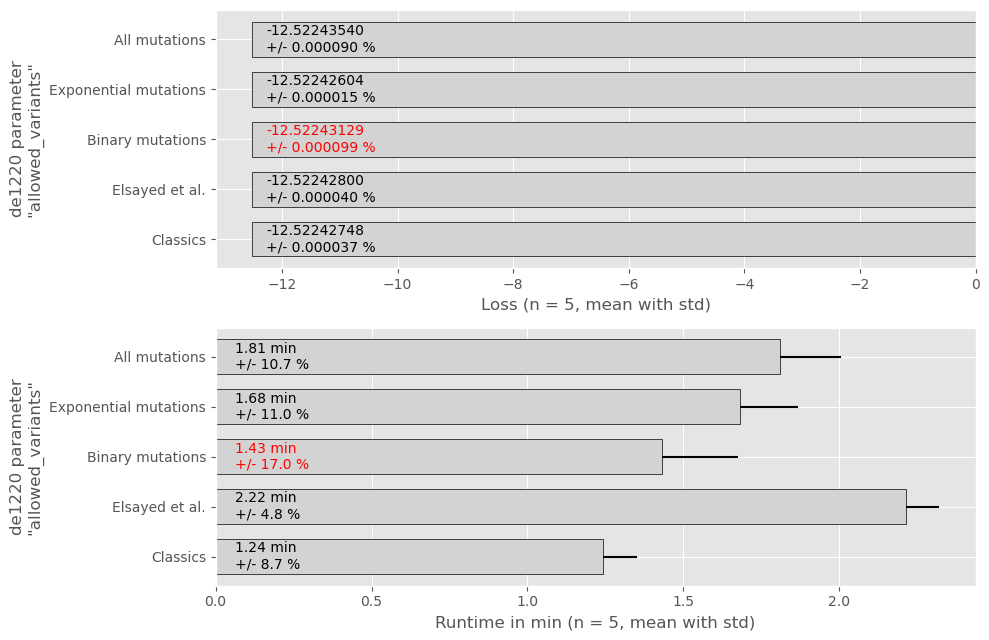

In [20]:
variant_descriptions = [
    'Classics',
    'Elsayed et al.',
    'Binary mutations',
    'Exponential mutations',
    'All mutations',
]

_best_index = extract_results(
    _results, 
    parameter='de1220 parameter\n"allowed_variants"', 
    parameter_values=variant_descriptions,
    decimals=decimals,
)

results_de1220['allowed_variants'] = allowed_variants[_best_index]

### 2.4 Compare combined tunings with default settings for `de1220`

In [21]:
results_de1220

{'rtol_islands': 1e-06,
 'n_cpus': 4,
 'gen': 50,
 'allowed_variants': [6, 7, 8, 9, 10, 12, 14, 16, 18]}

In [22]:
tunings = [
    {
        'optimizers' : [optimizer] * results_de1220['n_cpus'],
        'rtol_islands' : results_de1220['rtol_islands'],
        'optimizers_kwargs' : {
            'gen' : results_de1220['gen'], 
            'allowed_variants' : results_de1220['allowed_variants'],
        },
    },
    {}, # defaults
]

In [23]:
 tunings_results = estimate_parallel_wrapper(settings=tunings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 13.88 min


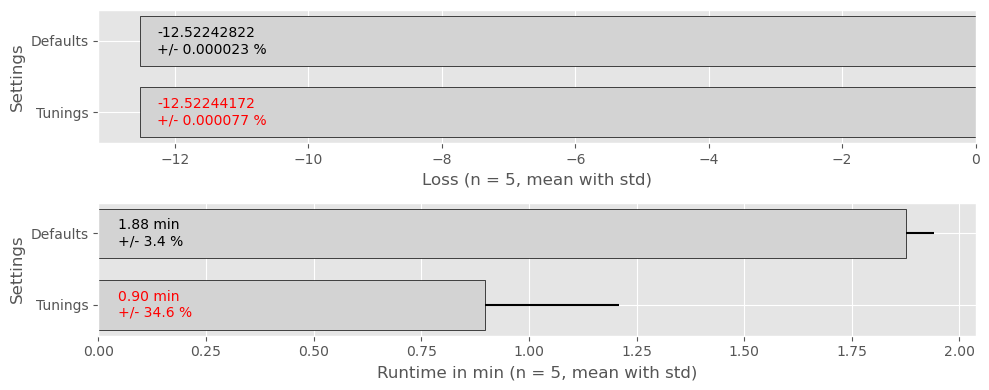

In [24]:
  _ = extract_results(
    tunings_results, 
    parameter='Settings', 
    parameter_values=['Tunings', 'Defaults'],
    decimals=decimals,
)

## 3. Settings for model calibation, using `compass_search`

In [25]:
results_compass_search = {}
optimizer = 'compass_search'

### 3.1. Convergence criterion `rtol_islands`

In [26]:
_settings = [
    {
        'optimizers' : optimizer, 
        'rtol_islands' : _rtol,
    } 
    for _rtol in rtols
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 2.85 min


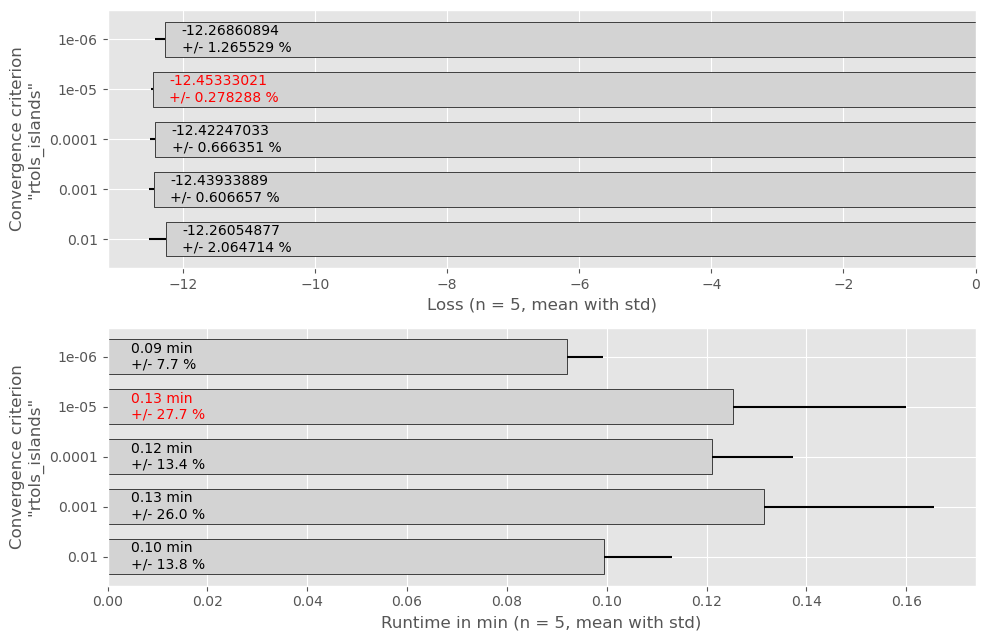

In [27]:
_best_index = extract_results(
    _results, 
    parameter='Convergence criterion\n"rtols_islands"', 
    parameter_values=rtols,
    decimals=decimals,
)

results_compass_search['rtol_islands'] = rtols[_best_index]

### 3.2. Number of parallel CPUs

In [28]:
_settings = [
    {
        'optimizers' : [optimizer]*_n_cpus,
    } 
    for _n_cpus in n_cpus
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 2.39 min


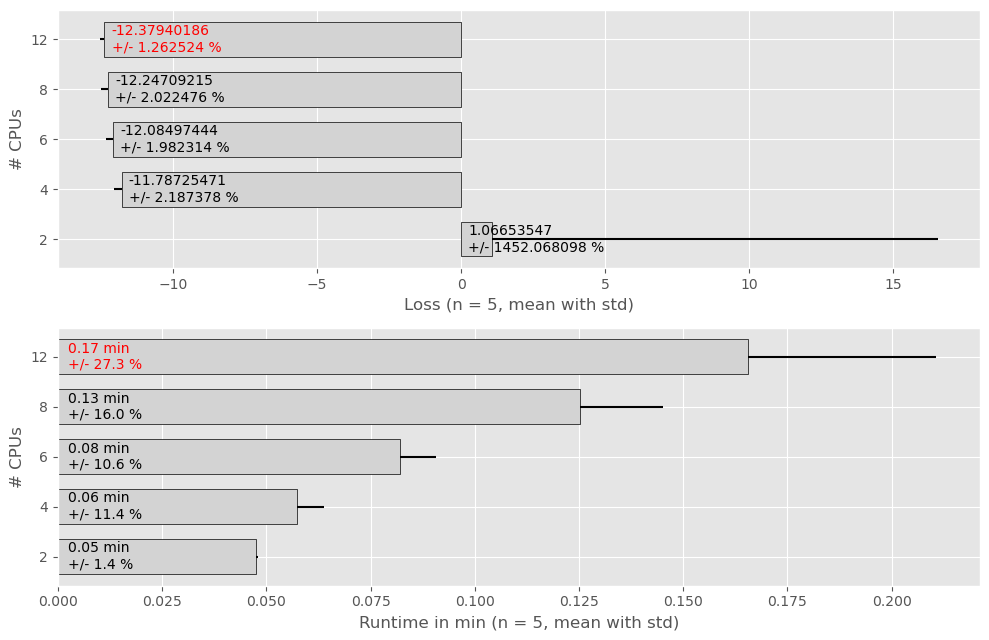

In [29]:
_best_index = extract_results(
    _results, 
    parameter='# CPUs', 
    parameter_values=n_cpus,
    decimals=decimals,
)

results_compass_search['n_cpus'] = n_cpus[_best_index]

### 3.3. `compass_search` parameter `max_fevals`

In [30]:
max_fevals = [10, 50, 100, 500, 1000, 5000]

_settings = [
    {
        'optimizers' : optimizer, 
        'optimizers_kwargs' : {
            'max_fevals' : _max_fevals,
        },
    }
    for _max_fevals in max_fevals
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 6.84 min


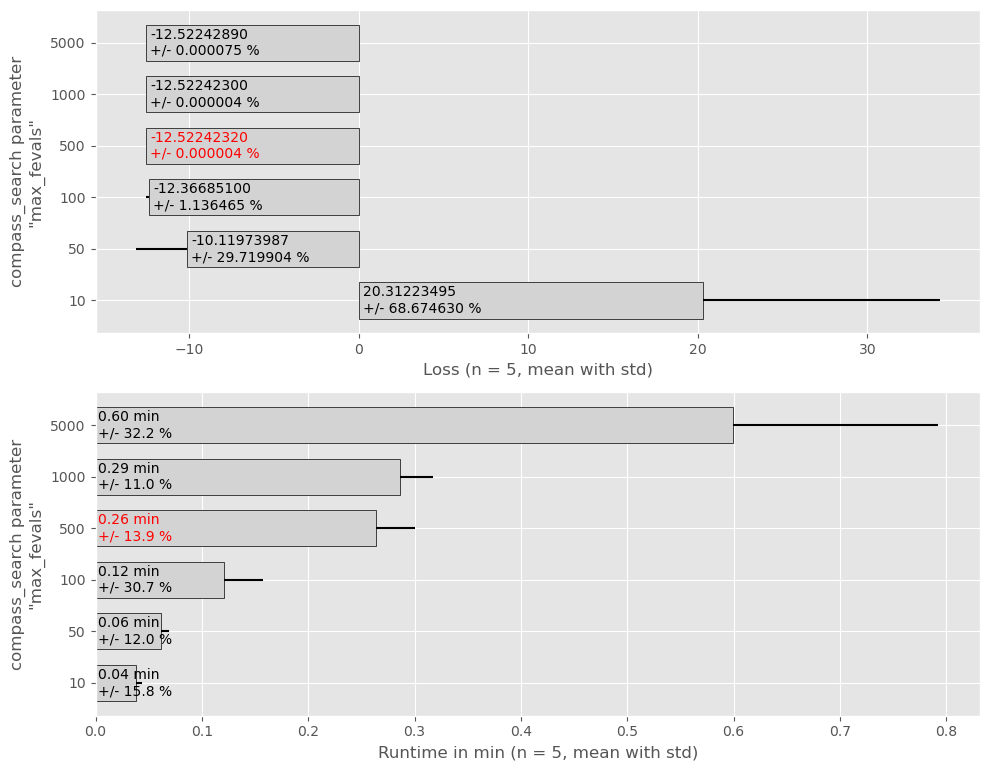

In [31]:
_best_index = extract_results(
    _results, 
    parameter='compass_search parameter\n"max_fevals"', 
    parameter_values=max_fevals,
    decimals=decimals,
)

results_compass_search['max_fevals'] = max_fevals[_best_index]

### 3.4. `compass_search` parameter `reduction_coeff`

In [32]:
reduction_coeff = [0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 0.99]

_settings = [
    {
        'optimizers' : optimizer, 
        'optimizers_kwargs' : {
            'reduction_coeff' : _reduction_coeff,
        },
    }
    for _reduction_coeff in reduction_coeff
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 5.09 min


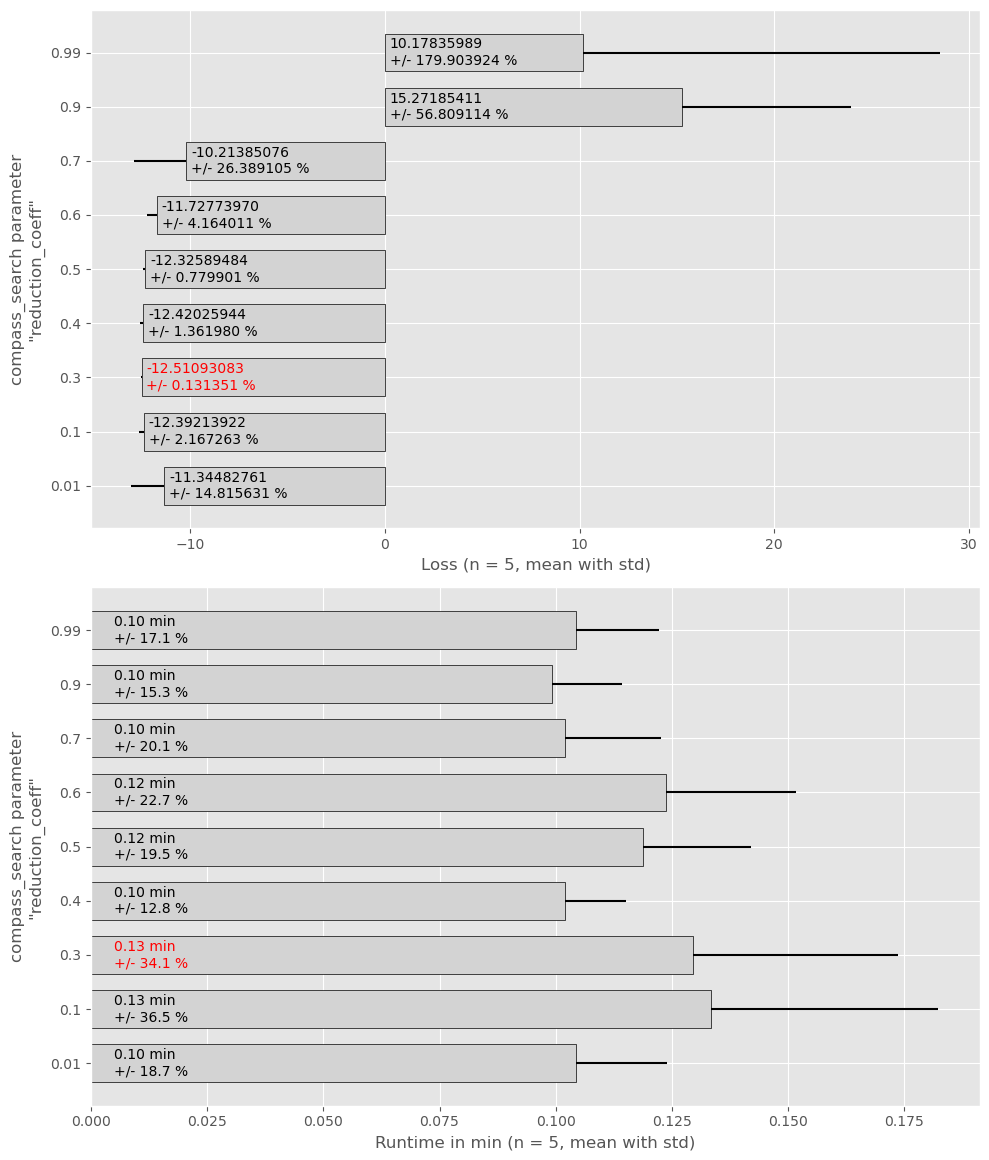

In [33]:
_best_index = extract_results(
    _results, 
    parameter='compass_search parameter\n"reduction_coeff"', 
    parameter_values=reduction_coeff,
    decimals=decimals,
)

results_compass_search['reduction_coeff'] = reduction_coeff[_best_index]

### 3.5. `compass_search` parameter `stop_range`

In [34]:
stop_range = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]

_settings = [
    {
        'optimizers' : optimizer, 
        'optimizers_kwargs' : {
            'stop_range' : _stop_range,
        },
    }
    for _stop_range in stop_range
]
_results = estimate_parallel_wrapper(settings=_settings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 3.37 min


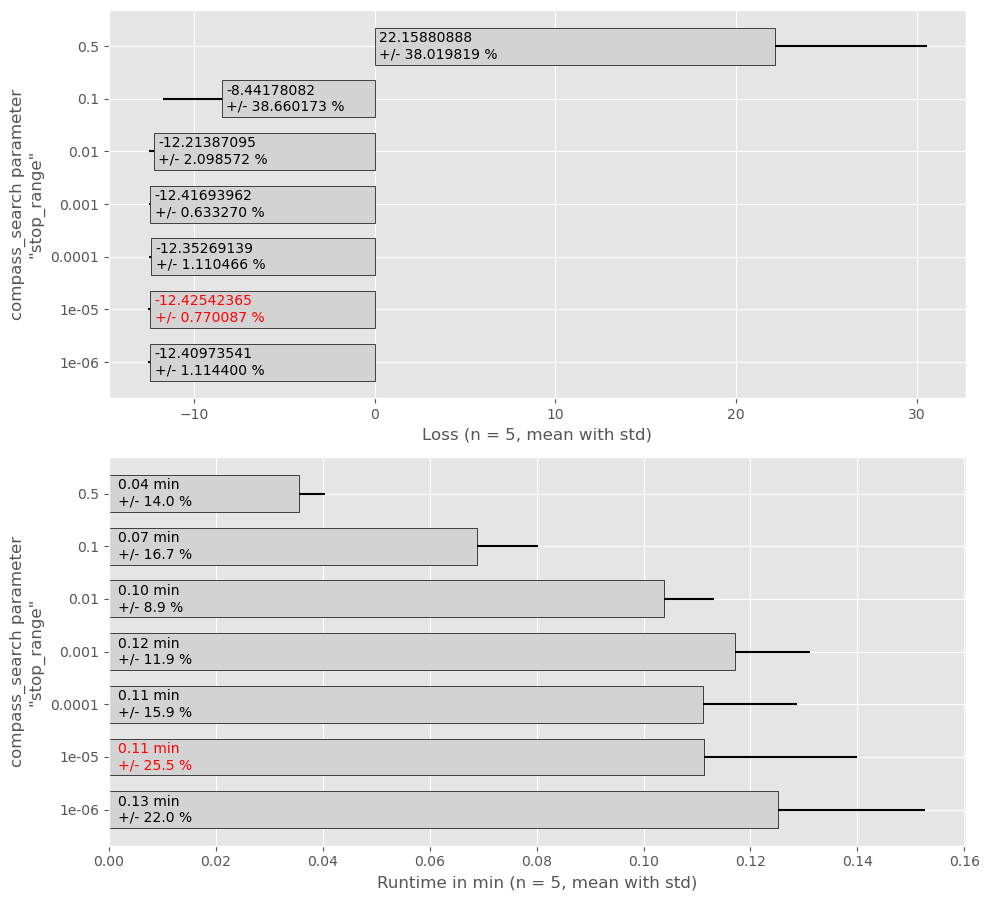

In [35]:
_best_index = extract_results(
    _results, 
    parameter='compass_search parameter\n"stop_range"', 
    parameter_values=stop_range,
    decimals=decimals,
)

results_compass_search['stop_range'] = stop_range[_best_index]

## 3.6 Compare combined tunings with default settings for `compass_search`

In [36]:
 results_compass_search

{'rtol_islands': 1e-05,
 'n_cpus': 12,
 'max_fevals': 500,
 'reduction_coeff': 0.3,
 'stop_range': 1e-05}

In [37]:
 tunings = [
    {
        'optimizers' : [optimizer] * results_compass_search['n_cpus'],
        'rtol_islands' : results_compass_search['rtol_islands'],
        'optimizers_kwargs' : {
            'max_fevals' : results_compass_search['max_fevals'],
            'reduction_coeff' : results_compass_search['reduction_coeff'], 
            'stop_range' : results_compass_search['stop_range'],
        },
    },
    {}, # defaults
]

In [38]:
 tunings_results = estimate_parallel_wrapper(settings=tunings, repeats=repeats)

Running repeat 1 of 5 repeats
Running repeat 2 of 5 repeats
Running repeat 3 of 5 repeats
Running repeat 4 of 5 repeats
Running repeat 5 of 5 repeats

Total runtime was 0.86 min


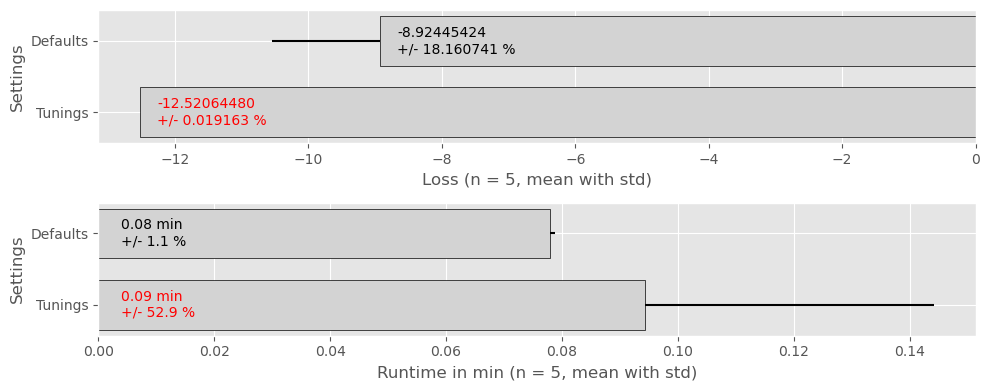

In [39]:
_ = extract_results(
    tunings_results, 
    parameter='Settings', 
    parameter_values=['Tunings', 'Defaults'],
    decimals=decimals,
)